In [19]:
from comet2 import Comet
from approximations import Approx as app
from asteroids import Asteroids
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import defaultdict
import seaborn as sns

In [2]:
dt = 0.001

@jit(forceobj = True)
def sim(V_init: int, M_init: float, angle: int = 45) -> tuple[np.ndarray, np.ndarray, np.ndarray, bool, int]:
    """
    Simulates the trajectory of a meteor given:
    The initial velocity, initial mass and angle of entry

    Returns multiple lists containing the mass, velocity and distance over time.
    """

    comet = Comet(V_init, M_init, angle)

    masses = np.zeros(900000)
    velocities = np.zeros(900000)
    heights = np.zeros(900000)
    t: int = 0
    while comet.m > 0 and comet.v > 0 and comet.h > 0 and t/dt < 900000:
        
        app.euler(dt, comet)
        app.velocity_verlet(dt, comet)

        masses[int(t/dt)] = comet.m
        velocities[int(t/dt)] = comet.v
        heights[int(t/dt)] = comet.h

        t += dt
    
    if comet.h <= 0:
        hit = True
    else: 
        hit = False

    return masses, velocities, heights, hit, t

Validation of the simulation

In [3]:
# Intial velocities and corresponding masses from Metha et al. (2018) article to validate simulation
init_velo = [10000, 14000, 18000, 22000, 26000, 30000, 34000, 38000]
init_mass = [0.05, 0.1, 0.2, 0.72, 2.64, 13.5, 132, 13000]

# For each velocity and mass, the error between the estimations from Mehta et al. and the simulation is calculated
errors: list[float] = []

for i in range(len(init_velo)):
    masses, velocities, distances, t, hit = sim(init_velo[i], init_mass[i])

    avg_velos = np.mean(velocities) 
   
    if masses[int(t/dt) - 1] < 0:
        erro = 0.02 / masses[0]
    else: erro = (0.02 - masses[int(t/dt) - 1]) / masses[0]

    errors.append(erro)



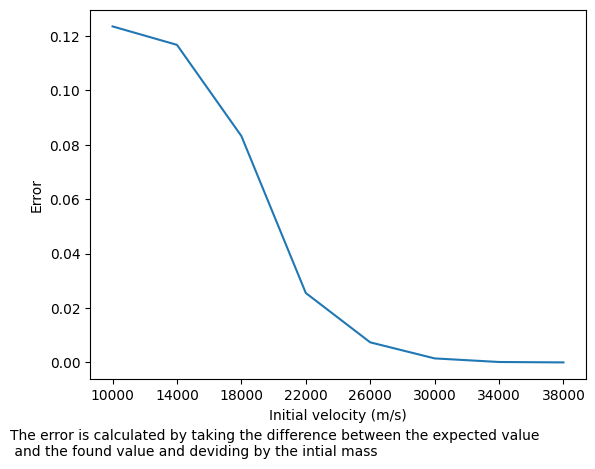

In [4]:
plt.plot(errors)
plt.xticks(ticks = list(range(8)), labels = init_velo)
plt.xlabel('Initial velocity (m/s)')
plt.ylabel('Error')
plt.figtext(0.0, -0.05 , 'The error is calculated by taking the difference between the expected value \n and the found value and deviding by the intial mass')
plt.show()

The experiment

For each of the given velocities and masses from the NASA dataset, the simulation will be run using different angels of impact. 
The results will be saved in a file.

In [5]:
filename = 'nasa_dataset\\impacts.csv'


asteroids = Asteroids(filename)
V_inits = asteroids.velocity()
M_inits = asteroids.mass()

In [6]:
print(V_inits[0])
print(M_inits[0])

17770.0
628580.3301057577


In [8]:
n = 30
results = defaultdict(dict)

for i in range(n):
    angle = np.random.rand() * 80
    masses, velocities, heights, hit, t = sim(V_inits[i], M_inits[i], angle)
    results[i][angle] = (masses[int(t/dt)-1], velocities[int(t/dt)-1], heights[int(t/dt)-1], hit, t)
    results[i]['angle'] = angle
    results[i]['height'] = heights[heights != 0]
    results[i]['mass'] = masses[masses != 0]
    results[i]['velocity'] = velocities[velocities != 0]
    results[i]['hit'] = hit


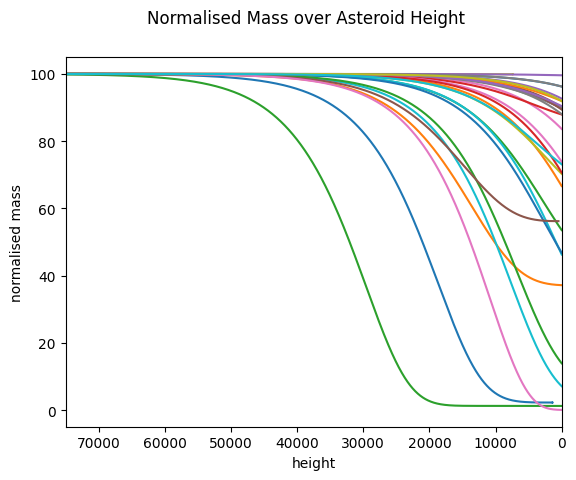

In [24]:
# colormap = sns.heatmap(M_inits, cmap=cm.coolwarm)

for i in range(n):
    norm_mass = [mass / results[i]['mass'][0] * 100 for mass in results[i]['mass']]  
    plt.plot(results[i]['height'], norm_mass)
    plt.xlim(75000, 0)

plt.xlabel('height')
plt.ylabel('normalised mass')
plt.suptitle('Normalised Mass over Asteroid Height')
plt.show()

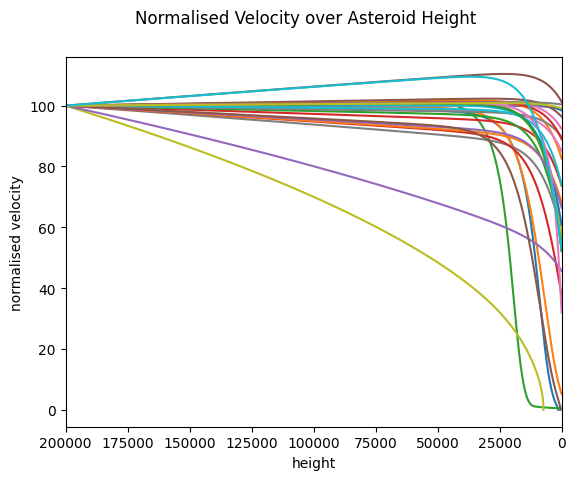

In [26]:
for i in range(n):
    norm_velo = [velo / results[i]['velocity'][0] * 100 for velo in results[i]['velocity']]  
    plt.plot(results[i]['height'], norm_velo)
    plt.xlim(200000, 0)

plt.xlabel('height')
plt.ylabel('normalised velocity')
plt.suptitle('Normalised Velocity over Asteroid Height')
plt.show()

The result dictionary looks like this:

{number of asteroid: {angle : (final mass, final velocity, final height, hit or not, duration of sim), angle : ..etc}}

Plot of the angle's effect on the change in velocity

the change in velocity will be:
(init_velo - final_velo) / init velo

In [11]:
angles_plt : list[float] = []
velo_change: list[float] = []

for asteroid in results:
    angles = results[asteroid].keys()
    for angle in angles:
        start_velo = V_inits[asteroid]
        end_velo = results[asteroid][angle][1]
        velo_change.append((start_velo - end_velo) / start_velo)
    angles_plt.extend(angles)

print(velo_change)
print(angles_plt)

TypeError: 'float' object is not subscriptable

Text(0, 0.5, 'Change in velocity ((initial - final) / initial)')

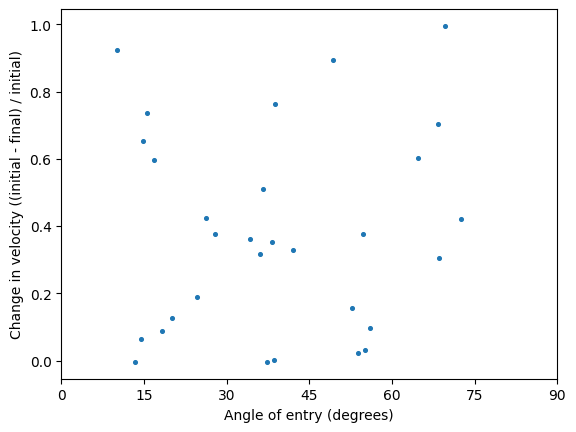

In [ ]:
plt.scatter(angles_plt, velo_change, s = 7 )
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Angle of entry (degrees)')
plt.ylabel('Change in velocity ((initial - final) / initial)')

# toevoegen hit or miss met kleuren


change in mass depending on angel of entry

In [ ]:
angles_plt2 : list[float] = []
mass_change: list[float] = []

for asteroid in results:
    angles = results[asteroid].keys()
    for angle in angles:
        start_mass = M_inits[asteroid]
        end_mass = results[asteroid][angle][0]
        mass_change.append((start_mass - end_mass) / start_mass)
    angles_plt2.extend(angles)

Text(0, 0.5, 'Change in mass ((initial - final) / initial)')

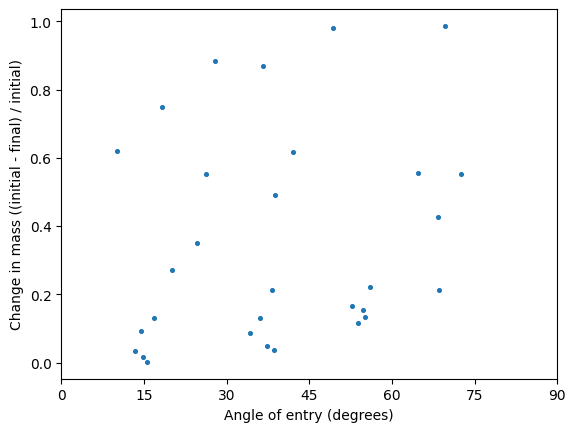

In [ ]:
plt.scatter(angles_plt2, mass_change, s = 7)
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Angle of entry (degrees)')
plt.ylabel('Change in mass ((initial - final) / initial)')

# toevoegen hit or miss met kleuren

In [ ]:
# scatterplot of change in velocity vs change in mass? for one angle

ding = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

for i in ding:
        masses, velocities, heights, hit, t = sim(V_inits[i], M_inits[i], 45.0)
        ding[i] = [masses[int(t/dt)-1], velocities[int(t/dt)-1], heights[int(t/dt)-1], hit, t]


In [ ]:
print(ding)

{0: [12604.693749131087, 2432.5766415573635, -0.8134628651627991, True, 17.262999999998115], 1: [5164.230758746707, 260.9262382583631, -0.007514742125371648, True, 44.6679999999866], 2: [212.0467063036552, 69.02674029653244, -0.04768105780139919, True, 100.26200000011468], 3: [6296831.260682706, 3709.022350608817, -1.737186857158231, True, 55.82799999996059], 4: [202395286374.53607, 19316.75957397585, -8.87378593148998, True, 14.512999999997396], 5: [2329497872.000439, 5915.540658401104, -0.026381811175462566, True, 46.45199999998244]}


In [ ]:
velo_change2 : list[float] = []
mass_change2: list[float] = []

for asteroid in ding:
    start_mass = M_inits[asteroid]
    end_mass = ding[asteroid][0]
    start_velo = V_inits[asteroid]
    end_velo = ding[asteroid][1]
    mass_change2.append((start_mass - end_mass) / start_mass)
    velo_change2.append((start_velo - end_velo) / start_velo)
    

Text(0, 0.5, 'Change in mass ((initial - final) / initial)')

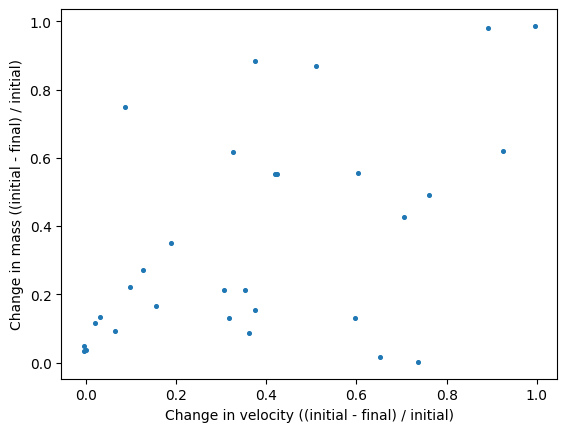

In [ ]:
plt.scatter(velo_change, mass_change, s = 7, )
plt.xlabel('Change in velocity ((initial - final) / initial)')
plt.ylabel('Change in mass ((initial - final) / initial)')

Average trajectory of the asteroid in terms of mass and velocity -> nathans plot

x-axis = height
y-axis = mass or velocity at that height

In [ ]:
traject = defaultdict(dict)

for i in range(2):
    angle = np.random.rand() * 80
    masses, velocities, heights, hit, t = sim(V_inits[i], M_inits[i], angle)
    traject[i][angle] = (masses, velocities, heights, hit, t)



